In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

## 1. Load Data

In [7]:
file_path = '../data/test_data/data-00000-of-00001.arrow'

with pa.memory_map(file_path, 'rb') as source:
    reader = pa.ipc.open_stream(source)
    df = reader.read_all().to_pandas()

print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.columns.tolist()}")

Rows: 2,795,918
Columns: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'treatment', 'conversion', 'visit', 'exposure', '__index_level_0__']


## 2. Check Data Imbalanceness

In [6]:
counts = df['treatment'].value_counts(normalize=True)
print(f"Treatment Ratio:\n{counts}")

Treatment Ratio:
treatment
1    0.849629
0    0.150371
Name: proportion, dtype: float64


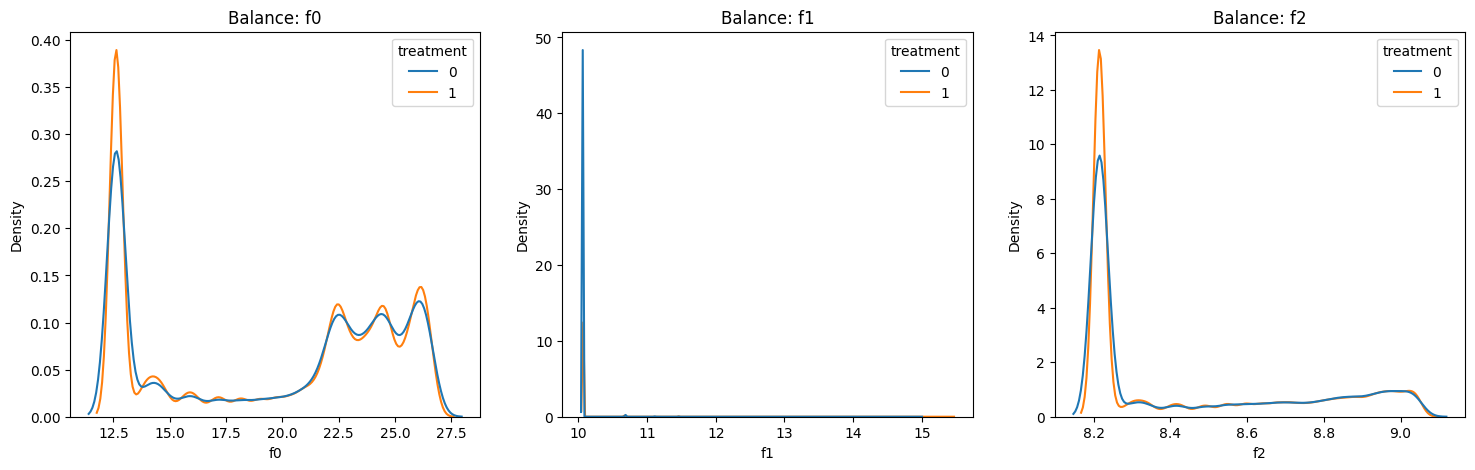

In [4]:
# Plotting distributions for key features
features_to_check = ['f0', 'f1', 'f2']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feat in enumerate(features_to_check):
    sns.kdeplot(data=df, x=feat, hue='treatment', ax=axes[i], common_norm=False)
    axes[i].set_title(f"Balance: {feat}")

plt.show()

In [9]:
conv_by_group = df.groupby('treatment')['conversion'].mean()
print(f"Conversion Rate: {conv_by_group}")

Conversion Rate: treatment
0    0.001874
1    0.003077
Name: conversion, dtype: float64


With a conversion rate of ~0.2%, the signal-to-noise ratio is incredibly low. Linear models often flatline on this data, justifying the use of gradient-boosted trees (XGBoost) which can capture rare, non-linear interactions.

## 3. Feature Correlation and Causal Assumptions

<Axes: >

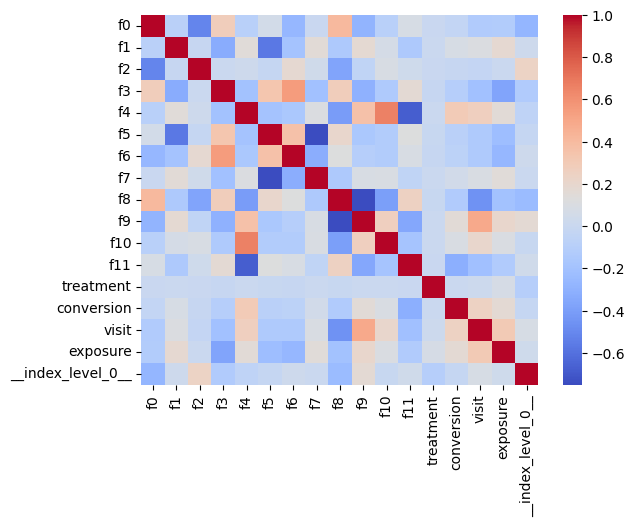

In [12]:
corr = df.corr()['conversion'].sort_values(ascending=False)
sns.heatmap(df.corr(), cmap='coolwarm')

There are correlations between features, an uplift model will be able to learn the structure of these features in conversion uplift

In [7]:
all_features = [f'f{i}' for i in range(12)]

stats = df.groupby('treatment')[all_features].agg(['mean', 'std']).T

stats.columns = ['Control', 'Treatment']
smd_results = {}

for feat in all_features:
    m1 = stats.loc[(feat, 'mean'), 'Treatment']
    m0 = stats.loc[(feat, 'mean'), 'Control']
    s1 = stats.loc[(feat, 'std'), 'Treatment']
    s0 = stats.loc[(feat, 'std'), 'Control']
    
    # |Mean_T - Mean_C| / sqrt((Std_T^2 + Std_C^2) / 2)
    smd = np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)
    smd_results[feat] = smd

smd_series = pd.Series(smd_results).sort_values(ascending=False)
print("--- Standardized Mean Difference (SMD) ---")
print(smd_series)

--- Standardized Mean Difference (SMD) ---
f3     0.046430
f6     0.040783
f5     0.028887
f9     0.022993
f1     0.022965
f8     0.022295
f7     0.019948
f10    0.012502
f4     0.008311
f2     0.006270
f0     0.005694
f11    0.002973
dtype: float64


All of SMD values are 0.1, we have uncounfoundedness in the data 

In [8]:
# Train a classifier to see if features predict 'treatment'
X_prop = df[[f'f{i}' for i in range(12)]]
y_prop = df['treatment']

prop_model = XGBClassifier(n_estimators=50, max_depth=3)
prop_model.fit(X_prop, y_prop)

auc = roc_auc_score(y_prop, prop_model.predict_proba(X_prop)[:, 1])
print(f"Propensity Score AUC: {auc:.4f}") 

Propensity Score AUC: 0.5142


Since our Propensity AUC is 0.5142 and all SMDs are < 0.1, the logging policy is effectively random. We assume the Conditional Independence Assumption (CIA) holds without additional weighting.

## 4. Feature Engineering for ads frequency

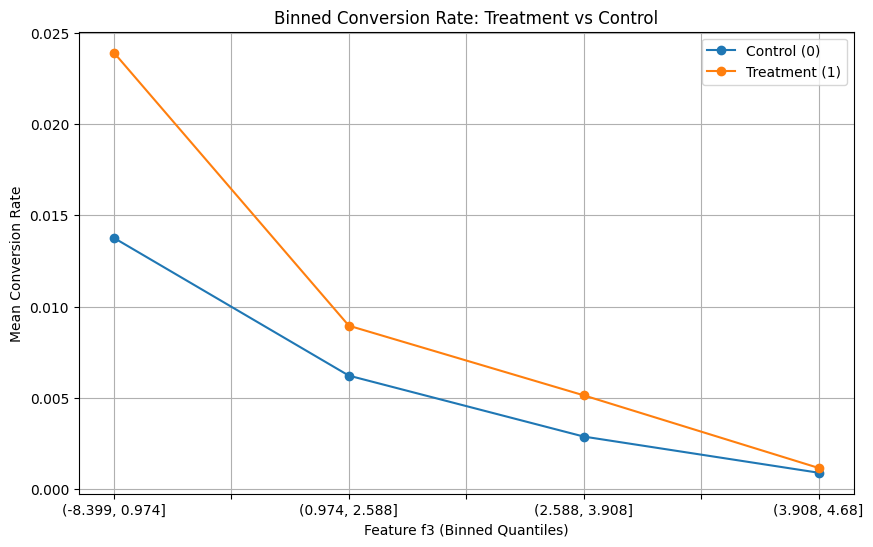

In [5]:
# Create bins for feature f3
df['f3_bin'] = pd.qcut(df['f3'], q=20, duplicates='drop')

# Calculate average conversion per bin and group
binned_eda = df.groupby(['f3_bin', 'treatment'])['conversion'].mean().unstack()

binned_eda.plot(marker='o', figsize=(10, 6))
plt.title("Binned Conversion Rate: Treatment vs Control")
plt.ylabel("Mean Conversion Rate")
plt.xlabel("Feature f3 (Binned Quantiles)")
plt.legend(['Control (0)', 'Treatment (1)'])
plt.grid(True)
plt.show()

Observation of Diminishing Returns: The binned analysis of $f3$ reveals that incremental lift (the gap between Treatment and Control) is highest at lower values but significantly narrows as $f3$ exceeds 3.9, indicating a saturation point where additional ad exposure yields near-zero marginal utility.

In [11]:
# Check for non-linear uplift across ALL features
important_feats = [f'f{i}' for i in range(12)]

for feat in important_feats:
    df[f'{feat}_bin'] = pd.qcut(df[feat], q=10, duplicates='drop')
    binned = df.groupby([f'{feat}_bin', 'treatment'])['conversion'].mean().unstack()
    
    # Calculate Lift: (Treatment - Control)
    lift = binned[1] - binned[0]
    
    # If the lift is NOT a flat line, it needs engineering
    if lift.std() > 0.001: # Threshold for 'interesting' variance
        print(f"Feature {feat} shows significant lift variance across bins with variances {lift.std():.4f}")

Feature f0 shows significant lift variance across bins with variances 0.0015
Feature f2 shows significant lift variance across bins with variances 0.0012
Feature f3 shows significant lift variance across bins with variances 0.0044
Feature f6 shows significant lift variance across bins with variances 0.0023
Feature f8 shows significant lift variance across bins with variances 0.0037
Feature f9 shows significant lift variance across bins with variances 0.0051
